# Artificial Neural Networks and Deep Learning  
## Assignment 3.3 - Self-attention and Transformers

Prof. Dr. Ir. Johan A. K. Suykens     

In this file, we first understand the self-attention mechanism by implementing it both with ``NumPy`` and ``PyTorch``.
Then, we implement a 6-layer Vision Transformer (ViT) and train it on the MNIST dataset.

All training will be conducted on a single T4 GPU.


In [18]:
# Please first load your google drive
# from google.colab import drive
# drive.mount('/content/drive')

In [19]:
# Please go to Edit > Notebook settings > Hardware accelerator > choose "T4 GPU"
# Now check if you have loaded the GPU successfully
# !nvidia-smi

In [20]:
import pickle
from pathlib import Path

class Store:
	"""
	TODO: Add "default" parameter to function like a defaultdict
	TODO: Add "expected keys" property to iterate over (non-)missing keys
			- Could also be based on a pydantic model to define expected structure
	TODO: Add method to remove unexpected keys
	"""
	def __init__(self, filename):
		self.filename = filename
		self.data = {}
		if Path(filename).exists():
			with open(filename, 'rb') as f:
				self.data = pickle.load(f)
		else:
			with open(filename, 'wb') as f:
				pickle.dump(self.data, f)

	def __getitem__(self, key):
		return self.data[key]
	
	def __setitem__(self, key, value):
		self.data[key] = value
		with open(self.filename, 'wb') as f:
			pickle.dump(self.data, f)

	def __contains__(self, key):
		return key in self.data
	
	def __delitem__(self, key):
		del self.data[key]
		with open(self.filename, 'wb') as f:
			pickle.dump(self.data, f)

	def __iter__(self):
		return iter(self.data)
	
	def __len__(self):
		return len(self.data)
	
	def keys(self):
		return self.data.keys()
	
	def values(self):
		return self.data.values()
	
	def items(self):
		return self.data.items()
	
	def clear(self):
		self.data.clear()
		with open(self.filename, 'wb') as f:
			pickle.dump(self.data, f)

	def __str__(self):
		return str(self.data)
	
	def __repr__(self):
		return repr(self.data)
	
	def __del__(self):
		with open(self.filename, 'wb') as f:
			pickle.dump(self.data, f)

# Self-attention Mechanism
Self-attention is the core mechanism in Transformer.

## Self-attention with NumPy
To have a better understanding of it, we first manually implement self-attention mechanism with ``numpy``. You can check the dimension of each variable during the matrix computation.

Feel free to change the dimensions of each variable and see how the output dimension will change accordingly.

In [21]:
import math
import numpy as np
from numpy.random import randn
from pathlib import Path

FIGURE_PATH = Path("../report/figures")

# I. Define the input data X
# X consists out of 32 samples, each sample has dimensionality 256
n = 32
d = 256
X = randn(n, d) # (32, 256)

# II. Generate the projection weights
Wq = randn(d, d) #(256, 256)
Wk = randn(d, d)
Wv = randn(d, d)

# III. Project X to find its query, keys and values vectors
Q = np.dot(X, Wq) # (32, 256)
K = np.dot(X, Wk)
V = np.dot(X, Wv)

# IV. Compute the self-attention score, denoted by A
# A = softmax(QK^T / \sqrt{d})
# Define the softmax function
def softmax(z):
    z = np.clip(z, 100, -100) # clip in case softmax explodes
    tmp = np.exp(z)
    res = np.exp(z) / np.sum(tmp, axis=1)
    return res

A = softmax(np.dot(Q, K.transpose())/math.sqrt(d)) #(32, 32)

# V. Compute the self-attention output
# outputs = A * V
outputs = np.dot(A, V) #(32, 256)

print("The attention outputs are\n {}".format(outputs))

The attention outputs are
 [[-3.5279123  -1.96080231 -1.15167238 ... -2.95900417  0.7092281
  -2.12301188]
 [-3.5279123  -1.96080231 -1.15167238 ... -2.95900417  0.7092281
  -2.12301188]
 [-3.5279123  -1.96080231 -1.15167238 ... -2.95900417  0.7092281
  -2.12301188]
 ...
 [-3.5279123  -1.96080231 -1.15167238 ... -2.95900417  0.7092281
  -2.12301188]
 [-3.5279123  -1.96080231 -1.15167238 ... -2.95900417  0.7092281
  -2.12301188]
 [-3.5279123  -1.96080231 -1.15167238 ... -2.95900417  0.7092281
  -2.12301188]]


## Self-attention with PyTorch
Now, we implement self-attention with ``PyTorch``, which is commonly used when building Transformers.

Feel free to change the dimensions of each variable and see how the output dimension will change accordingly.

In [22]:
import math
import torch
import torch.nn as nn

class SelfAttention(nn.Module):
    def __init__(self, dim_input, dim_q, dim_v):
        '''
        dim_input: the dimension of each sample
        dim_q: dimension of Q matrix, should be equal to dim_k
        dim_v: dimension of V matrix, also the  dimension of the attention output
        '''
        super(SelfAttention, self).__init__()

        self.dim_input = dim_input
        self.dim_q = dim_q
        self.dim_k = dim_q
        self.dim_v = dim_v

        # Define the linear projection
        self.linear_q = nn.Linear(self.dim_input, self.dim_q, bias=False)
        self.linear_k = nn.Linear(self.dim_input, self.dim_k, bias=False)
        self.linear_v = nn.Linear(self.dim_input, self.dim_v, bias=False)
        self._norm_fact = 1 / math.sqrt(self.dim_k)

    def forward(self, x):
        batch, n, dim_q = x.shape

        q = self.linear_q(x) # (batchsize, seq_len, dim_q)
        k = self.linear_k(x) # (batchsize, seq_len, dim_k)
        v = self.linear_v(x) # (batchsize, seq_len, dim_v)
        print(f'x.shape:{x.shape} \n Q.shape:{q.shape} \n K.shape:{k.shape} \n V.shape:{v.shape}')

        dist = torch.bmm(q, k.transpose(1,2)) * self._norm_fact
        dist = torch.softmax(dist, dim=-1)
        print('attention matrix: ', dist.shape)

        outputs = torch.bmm(dist, v)
        print('attention outputs: ', outputs.shape)

        return outputs


batch_size = 32 # number of samples in a batch
dim_input = 128 # dimension of each item in the sample sequence
seq_len = 20 # sequence length for each sample
x = torch.randn(batch_size, seq_len, dim_input)
self_attention = SelfAttention(dim_input, dim_q = 64, dim_v = 32)

attention = self_attention(x)

print(attention)

x.shape:torch.Size([32, 20, 128]) 
 Q.shape:torch.Size([32, 20, 64]) 
 K.shape:torch.Size([32, 20, 64]) 
 V.shape:torch.Size([32, 20, 32])
attention matrix:  torch.Size([32, 20, 20])
attention outputs:  torch.Size([32, 20, 32])
tensor([[[ 0.0925, -0.1243,  0.0035,  ..., -0.1726, -0.0626,  0.2192],
         [ 0.0393, -0.0528,  0.0338,  ..., -0.1209,  0.0259,  0.3022],
         [ 0.0438, -0.1083,  0.0151,  ..., -0.2410, -0.0749,  0.3585],
         ...,
         [ 0.0992, -0.0442, -0.0219,  ..., -0.2382, -0.2141,  0.3080],
         [ 0.1225, -0.1314, -0.0034,  ..., -0.2117, -0.0582,  0.0981],
         [ 0.0430, -0.1030,  0.0585,  ..., -0.3413, -0.1247,  0.2808]],

        [[-0.1428,  0.2679,  0.1408,  ...,  0.0352, -0.0580,  0.0792],
         [-0.0842,  0.2698,  0.1667,  ...,  0.0574,  0.0110,  0.1966],
         [-0.1172,  0.0103,  0.1846,  ...,  0.0377, -0.0461,  0.1214],
         ...,
         [-0.1607,  0.2252,  0.0799,  ...,  0.0043, -0.0240,  0.2271],
         [-0.0765,  0.2453,  0.0

# Transformers
In this section, we implement a 6-layer Vision Transformer (ViT) and trained it on the MNIST dataset.
We consider the classification tasks.
First, we load the MNIST dataset as follows:

In [23]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, utils
from torchvision.datasets import MNIST

def get_mnist_loader(batch_size=100, shuffle=True):
    """

    :return: train_loader, test_loader
    """
    train_dataset = MNIST(root='./data',
                          train=True,
                          transform=torchvision.transforms.ToTensor(),
                          download=True)
    test_dataset = MNIST(root='./data',
                         train=False,
                         transform=torchvision.transforms.ToTensor(),
                         download=True)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               shuffle=shuffle)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False)
    return train_loader, test_loader

In [24]:
# This package is needed to build the transformer
# !pip install einops

## Build ViT from scratch
Recall that each Transformer block include 2 modules: the self-attention module, the feedforward module.

In [25]:
from einops import rearrange
import torch.nn.functional as F


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv=3, h=h)

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, float('-inf'))
            del mask

        attn = dots.softmax(dim=-1)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ]))

    def forward(self, x, mask=None):
        for attn, ff in self.layers:
            x = attn(x, mask=mask)
            x = ff(x)
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
        super().__init__()
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer(dim, depth, heads, mlp_dim)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(), # Gaussian Error Linear Units is another type of activation function
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img, mask=None):
        p = self.patch_size

        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        x = self.patch_to_embedding(x)

        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.transformer(x, mask)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

## Training and test function


In [26]:
def train_epoch(model, optimizer, data_loader, loss_history):
    total_samples = len(data_loader.dataset)
    model.train()

    for i, (data, target) in enumerate(data_loader):
        # data = data.cuda()
        # target = target.cuda()
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
        loss_history.append(loss.item())

In [27]:
def evaluate(model, data_loader, loss_history):
    model.eval()

    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    # We do not need to remember the gradients when testing
    # This will help reduce memory
    with torch.no_grad():
        for data, target in data_loader:
            # data = data.cuda()
            # target = target.cuda()
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)

            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()
            loss_history.append(loss.item())

    avg_loss = total_loss / total_samples
    # loss_history.append(avg_loss)
    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')
    return correct_samples / total_samples

## Let's start training!
Here, you can change the ViT structure by changing the hyper-parametrs inside ``ViT`` function.
The default settings are with 6 layers, 8 heads for the multi-head attention mechanism and embedding dimension of 64.
You can also increase the number of epochs to obtain better results.

In [36]:
import time

# You can change the architecture here
model = ViT(image_size=28, patch_size=7, num_classes=10, channels=1,
            dim=64, depth=6, heads=8, mlp_dim=128)
# model = model.cuda()
# We also print the network architecture
model

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss_history, test_loss_history = [], []

In [37]:
N_EPOCHS = 20

train_loader, test_loader = get_mnist_loader(batch_size=128, shuffle=True)

# Gradually reduce the learning rate while training
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

start_time = time.time()
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch,'LR:', scheduler.get_last_lr())
    train_epoch(model, optimizer, train_loader, train_loss_history)
    evaluate(model, test_loader, test_loss_history)
    scheduler.step()

print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

Epoch: 1 LR: [0.001]
[    0/60000 (  0%)]  Loss: 2.3848
[12800/60000 ( 21%)]  Loss: 0.9746


KeyboardInterrupt: 

In [40]:
import time
from itertools import product

range_dim = [32, 64, 128]
range_depth = [4, 6, 8]
range_heads = [8]
range_mlp_dim = [64, 128, 256]

add_range_dim = [256]
add_range_depth = [10]
add_range_heads = []
add_range_mlp_dim = [512]

store = Store('results.pkl')
N_EPOCHS = 20

# Shuffle the order of the experiments
all_ranges = list(product(range_dim, range_depth, range_heads, range_mlp_dim))
new_ranges = product(range_dim + add_range_dim, range_depth + add_range_depth,
                      range_heads + add_range_heads, range_mlp_dim + add_range_mlp_dim)
new_ranges = list(new_ranges)
np.random.shuffle(new_ranges)

for dim, depth, heads, mlp_dim in new_ranges:
    if (dim, depth, heads, mlp_dim) in store:
        continue
    if (dim, depth, heads, mlp_dim) in all_ranges:
        continue
    print('-----------------------------------------------------------------------------------')
    print(f'Running experiment with dim={dim}, depth={depth}, heads={heads}, mlp_dim={mlp_dim}')
    model = ViT(image_size=28, patch_size=7, num_classes=10, channels=1,
                dim=dim, depth=depth, heads=heads, mlp_dim=mlp_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_loss_history, test_loss_history = [], []
    train_loader, test_loader = get_mnist_loader(batch_size=128, shuffle=True)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    start_time = time.time()
    for epoch in range(1, N_EPOCHS + 1):
        print('Epoch:', epoch,'LR:', scheduler.get_last_lr())
        train_epoch(model, optimizer, train_loader, train_loss_history)
        accuracy = evaluate(model, test_loader, test_loss_history)
        scheduler.step()
    store[(dim, depth, heads, mlp_dim)] = {
        'train_loss': train_loss_history,
        'test_loss': test_loss_history,
        'accuracy': float(accuracy),
        'execution_time': time.time() - start_time
    }
    print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')
    print('-----------------------------------------------------------------------------------')


-----------------------------------------------------------------------------------
Running experiment with dim=256, depth=8, heads=8, mlp_dim=128
Epoch: 1 LR: [0.001]
[    0/60000 (  0%)]  Loss: 2.3744
[12800/60000 ( 21%)]  Loss: 0.3310
[25600/60000 ( 43%)]  Loss: 0.3602
[38400/60000 ( 64%)]  Loss: 0.1913
[51200/60000 ( 85%)]  Loss: 0.2411

Average test loss: 0.1320  Accuracy: 9577/10000 (95.77%)

Epoch: 2 LR: [0.00095]
[    0/60000 (  0%)]  Loss: 0.0653
[12800/60000 ( 21%)]  Loss: 0.1206
[25600/60000 ( 43%)]  Loss: 0.0697
[38400/60000 ( 64%)]  Loss: 0.1285
[51200/60000 ( 85%)]  Loss: 0.1127

Average test loss: 0.1178  Accuracy: 9622/10000 (96.22%)

Epoch: 3 LR: [0.0009025]
[    0/60000 (  0%)]  Loss: 0.1398
[12800/60000 ( 21%)]  Loss: 0.0879
[25600/60000 ( 43%)]  Loss: 0.0674
[38400/60000 ( 64%)]  Loss: 0.1428
[51200/60000 ( 85%)]  Loss: 0.0757

Average test loss: 0.0890  Accuracy: 9716/10000 (97.16%)

Epoch: 4 LR: [0.000857375]
[    0/60000 (  0%)]  Loss: 0.0569
[12800/60000 ( 21%)]

KeyboardInterrupt: 

In [93]:
import latextable
from texttable import Texttable

with open('results_kaggle.pkl', 'rb') as f:
    new_values = pickle.load(f)
    for key, value in new_values.items():
        if key not in store:
            store[key] = value

table_1 = Texttable()
table_1.set_cols_align(["c", "c", "c", "c", "c", "c"])
table_1.set_precision(4)

items = list(store.items())
items.sort(key=lambda x: x[1]['accuracy'], reverse=True)
rows = [[
    "\\textbf{Rank}",
    "\\textbf{\\texttt{dim}}",
    "\\textbf{\\texttt{depth}}",
    "\\textbf{\\texttt{mlp\\_dim}}",
    "\\textbf{\\texttt{accuracy}}",
    "\\textbf{\\texttt{Exec Time}}"
]]
for i, (key, value) in enumerate(items):
    rows.append([i + 1, key[0], key[1], key[3], float(value['accuracy']), f"{value['execution_time']:.1f}s"])

table_1.add_rows(rows)
# print(table_1.draw())
print(latextable.draw_latex(
    table_1,
    caption="Accuracy of different Transformer models on MNIST dataset",
    label="tab:transformer_accuracy",
    position="htbp"
))

\begin{table}[htbp]
	\begin{center}
		\begin{tabular}{|c|c|c|c|c|c|}
			\hline
			\textbf{Rank} & \textbf{\texttt{dim}} & \textbf{\texttt{depth}} & \textbf{\texttt{mlp\_dim}} & \textbf{\texttt{accuracy}} & \textbf{\texttt{Exec Time}} \\
			\hline
			1 & 128 & 8 & 128 & 0.9871 & 351.1s \\
			\hline
			2 & 128 & 6 & 256 & 0.9863 & 309.6s \\
			\hline
			3 & 128 & 4 & 512 & 0.9860 & 455.0s \\
			\hline
			4 & 256 & 4 & 512 & 0.9859 & 730.3s \\
			\hline
			5 & 128 & 8 & 64 & 0.9857 & 351.4s \\
			\hline
			6 & 64 & 8 & 128 & 0.9856 & 356.4s \\
			\hline
			7 & 64 & 4 & 128 & 0.9851 & 264.4s \\
			\hline
			8 & 64 & 8 & 256 & 0.9849 & 355.6s \\
			\hline
			9 & 64 & 6 & 128 & 0.9847 & 310.6s \\
			\hline
			10 & 32 & 8 & 128 & 0.9845 & 350.2s \\
			\hline
			11 & 128 & 6 & 128 & 0.9842 & 500.1s \\
			\hline
			12 & 128 & 8 & 256 & 0.9841 & 352.6s \\
			\hline
			13 & 256 & 8 & 64 & 0.9839 & 999.3s \\
			\hline
			14 & 128 & 10 & 64 & 0.9838 & 710.6s \\
			\hline
			15 & 128 & 6 & 64 & 0.98

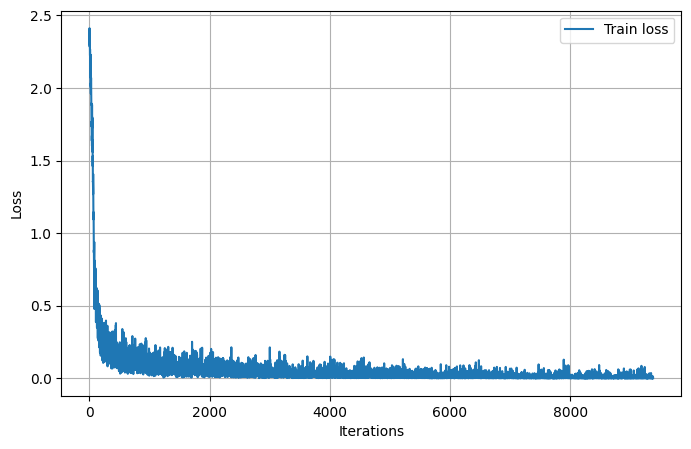

In [94]:
import matplotlib.pyplot as plt

# Plot train loss of the best model
best_model = items[0][1]
plt.figure(figsize=(8, 5))
plt.plot(best_model['train_loss'], label='Train loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig(FIGURE_PATH / 'ex3_3_train_loss.pdf')
plt.show()
